# practice 3. 다중 선형 회귀, ridge, lasso

데이터 셋 링크: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data

펭귄들의 종, 서식 지역, 부리 길이와 부리 깊이, 날개(?) 사이즈, 성별, 그리고 몸무게 데이터 셋이 있습니다. 다중 회귀 분석, 라쏘, 릿지 리그레션을 이용해서 몸무게를 예측하는 회귀 모델을 만들고, 어떤 독립변수가 가장 몸무게에 영향을 많이 미치는지 찾아보세요.

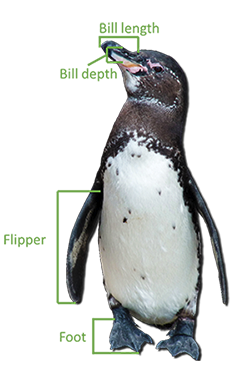

In [53]:
from utils import load_penguin_dataset

x_train, x_test, y_train, y_test = load_penguin_dataset()

In [54]:
x_train

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex
225,Gentoo,Biscoe,46.5,13.5,210.0,FEMALE
119,Adelie,Torgersen,41.1,18.6,189.0,MALE
181,Chinstrap,Dream,52.8,20.0,205.0,MALE
167,Chinstrap,Dream,50.5,19.6,201.0,MALE
226,Gentoo,Biscoe,45.4,14.6,211.0,FEMALE
...,...,...,...,...,...,...
205,Chinstrap,Dream,50.7,19.7,203.0,MALE
54,Adelie,Biscoe,34.5,18.1,187.0,FEMALE
295,Gentoo,Biscoe,48.6,16.0,230.0,MALE
212,Chinstrap,Dream,51.9,19.5,206.0,MALE


In [55]:
y_train = (y_train - y_train.mean()) / y_train.std()

In [56]:
import pandas as pd

In [57]:
species_dummies = pd.get_dummies(x_train["species"], prefix="species")
island_dummies = pd.get_dummies(x_train["island"], prefix="island")

In [58]:
x_train = pd.concat([x_train, species_dummies, island_dummies], axis=1)

In [59]:
x_train = x_train.drop(["species", "island"], axis=1)

In [60]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()
x_train["sex"] = label_encoder.fit_transform(x_train[["sex"]]) 
x_train[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm"]] = standard_scaler.fit_transform(x_train[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm"]])

/Users/user/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
x_train

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen
225,0.477065,-1.801483,0.621958,1,0,0,1,1,0,0
119,-0.533118,0.752957,-0.861889,2,1,0,0,0,0,1
181,1.655611,1.454176,0.268661,2,0,1,0,0,1,0
167,1.225348,1.253828,-0.013977,2,0,1,0,0,1,0
226,0.271287,-1.250525,0.692617,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
205,1.262762,1.303915,0.127342,2,0,1,0,0,1,0
54,-1.767785,0.502522,-1.003208,1,1,0,0,1,0,0
295,0.869914,-0.549306,2.035145,2,0,0,1,1,0,0
212,1.487248,1.203741,0.339320,2,0,1,0,0,1,0


In [62]:
y_train

225    0.413411
119   -1.096336
181    0.413411
167   -0.202812
226    0.721523
         ...   
205   -0.202812
54    -1.620126
295    1.953970
212   -0.326057
304    0.659901
Name: body_mass_g, Length: 273, dtype: float64

In [63]:
import statsmodels.api as sm

def train(X, y):
    X_constant = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, X_constant)
    results = model.fit()
    print(results.summary())

In [75]:
x_train = x_train.drop(["culmen_depth_mm"], axis=1)
train(x_train, y_train)

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     338.7
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          1.78e-103
Time:                        15:51:06   Log-Likelihood:                -141.05
No. Observations:                 273   AIC:                             292.1
Df Residuals:                     268   BIC:                             310.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1672      0.08

In [76]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def check_multi_colinearity(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif = vif.sort_values(by="VIF", ascending=False)
    return vif

In [80]:
check_multi_colinearity(x_train)

,Features,VIF
4,weight,5.968681
1,flipper_length_mm,5.038959
0,culmen_length_mm,4.913944
3,species_Chinstrap,3.713971
2,sex,1.644597


In [78]:
x_train["weight"] = y_train